In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Task 1: Load the Data* and Make Transformations

*Data Source: U.S. Census Bureau and U.S. Department of Housing and Urban Development, New One Family Houses Sold: United States HSN1F, 
retrieved from FRED, Federal Reserve Bank of St. Louis; 
https://fred.stlouisfed.org/series/HSN1F, March 3

In [2]:
houseSales = pd.read_csv('new_one_family_houses.csv')
scaler = MinMaxScaler()
scaler.fit(houseSales.Sales.values.reshape(-1,1))
houseSalesScaled = scaler.transform(houseSales.Sales.values.reshape(-1,1))
houseSales['houseSalesScaled'] = houseSalesScaled
houseSales.head()

,Unnamed: 0,Sales,houseSalesScaled
0,1963-01-01,591.0,0.286863
1,1963-02-01,464.0,0.173369
2,1963-03-01,461.0,0.170688
3,1963-04-01,605.0,0.299374
4,1963-05-01,586.0,0.282395


In [3]:
houseSales.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

### Task 2: Descriptive Statistics and Visualizations of the Data.

In [4]:
houseSales.describe()

,Sales,houseSalesScaled
count,697.000000,697.000000
mean,654.005739,0.343169
std,211.685830,0.189174
min,270.000000,0.000000
25%,510.000000,0.214477
50%,625.000000,0.317248
75%,767.000000,0.444147
max,1389.000000,1.000000


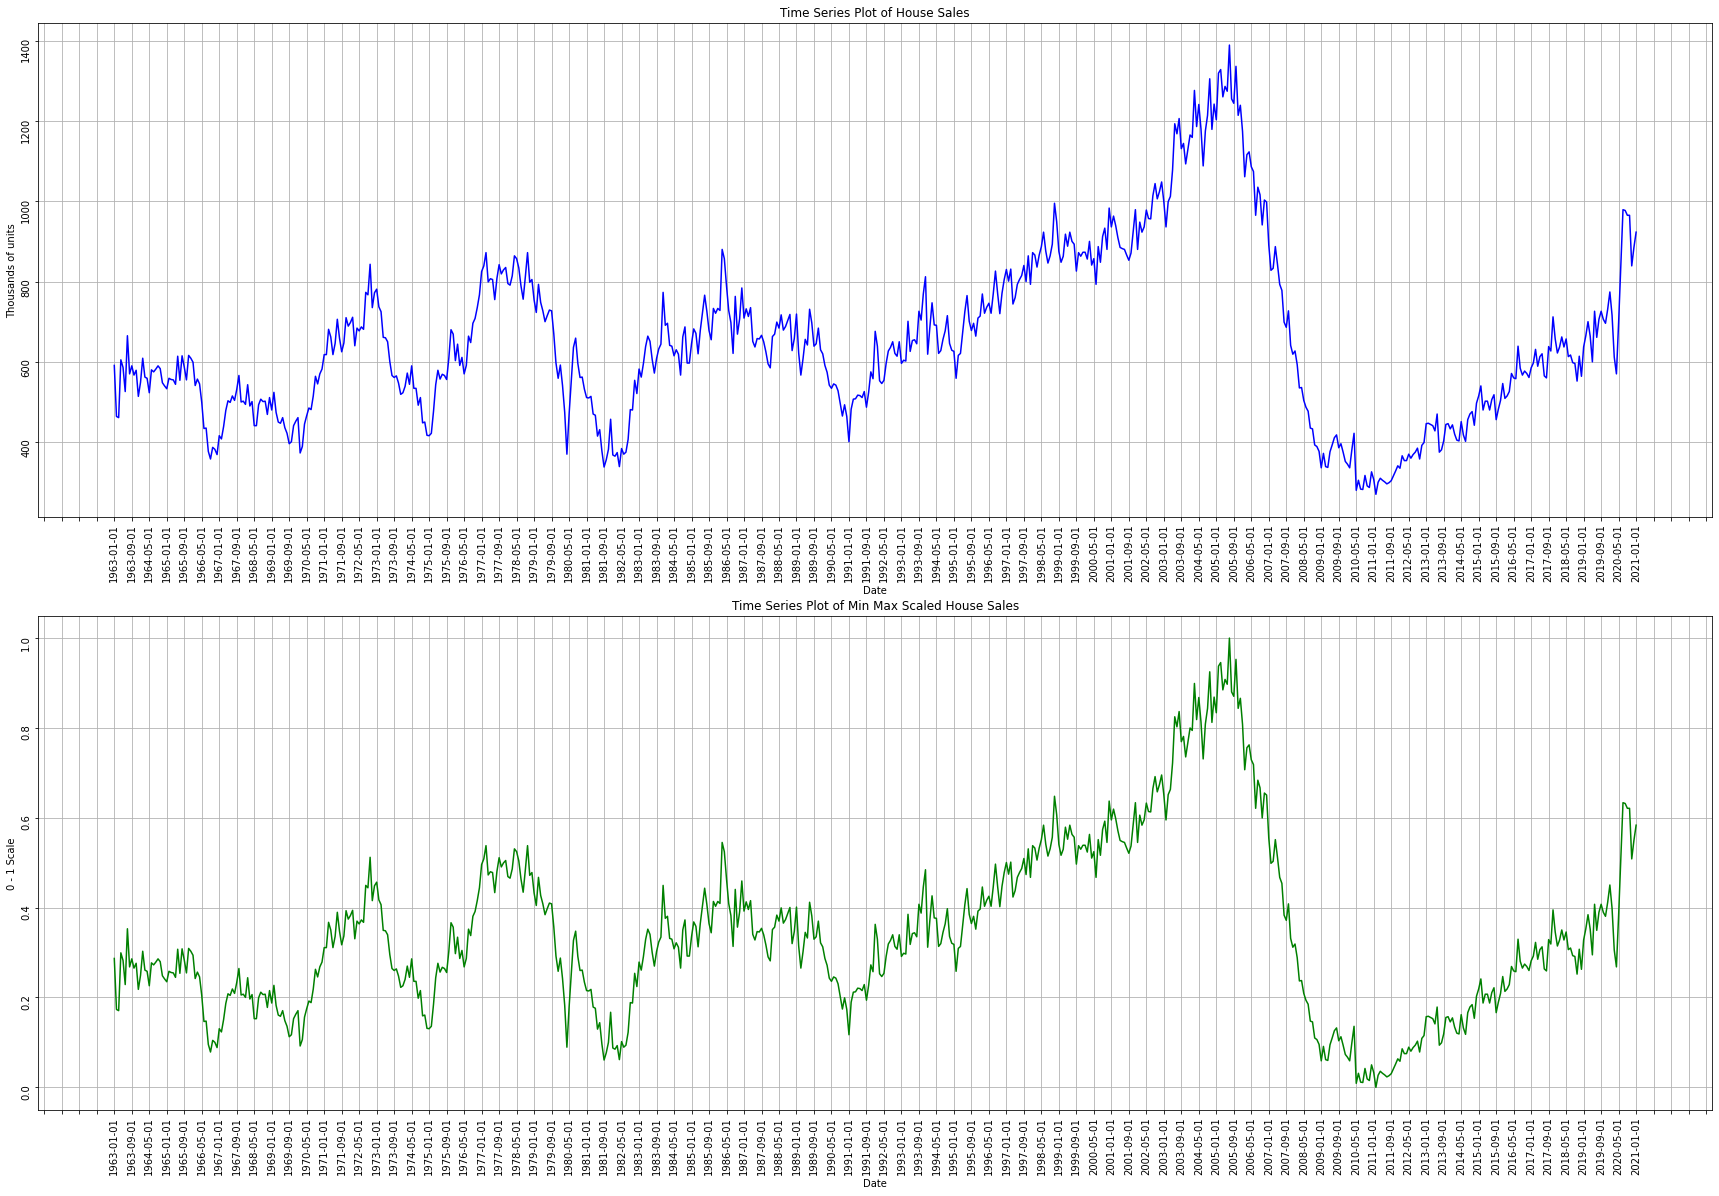

In [5]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(houseSales.Date, houseSales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(houseSales.Date, houseSales.houseSalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('0 - 1 Scale')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)

plt.savefig('image1.png')
plt.show()

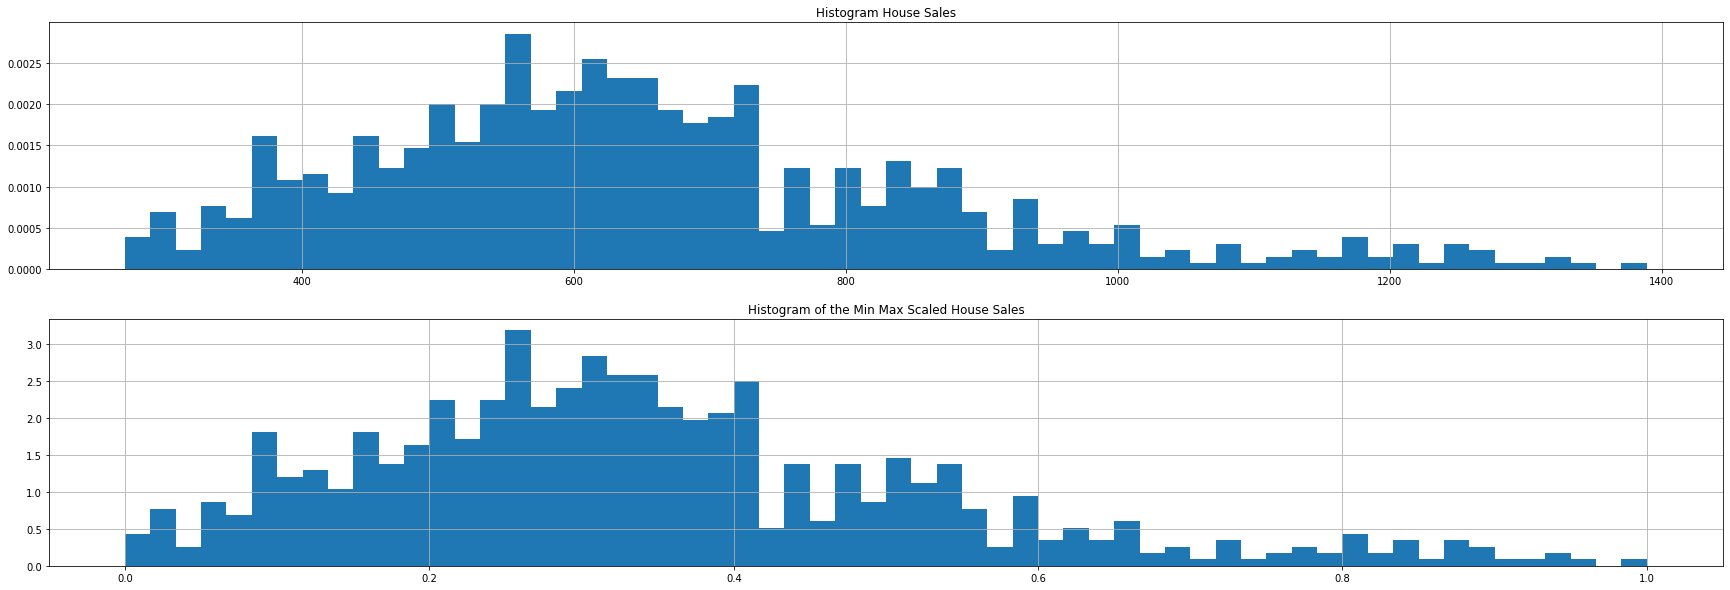

In [6]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(houseSales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(houseSales.houseSalesScaled, density=True, bins=60)
ax2.title.set_text("Histogram of the Min Max Scaled House Sales")
ax2.grid(True)

plt.savefig('image2.png')
plt.show()

### Task 3: Unit Root Tests.

In [7]:
result = adfuller(houseSales.Sales.values, autolag='AIC')
print(f'ADF Statistic:{result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values :')
    print(f' {key}, {value}')

ADF Statistic:-2.8085520725549897
p-value: 0.05706251126952963
Critical values :
 1%, -3.4400605106273368
Critical values :
 5%, -2.865824986587412
Critical values :
 10%, -2.5690518865761


In [8]:
result = adfuller(houseSales.houseSalesScaled.values, autolag='AIC')
print(f'ADF Statistic:{result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values :')
    print(f' {key}, {value}')

ADF Statistic:-2.808552072555019
p-value: 0.057062511269525495
Critical values :
 1%, -3.4400605106273368
Critical values :
 5%, -2.865824986587412
Critical values :
 10%, -2.5690518865761


### Task 4: Autocorrelations and Partial Autocorrelations Plots.

In [9]:
acfSalesScaled = acf(houseSales.houseSalesScaled, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

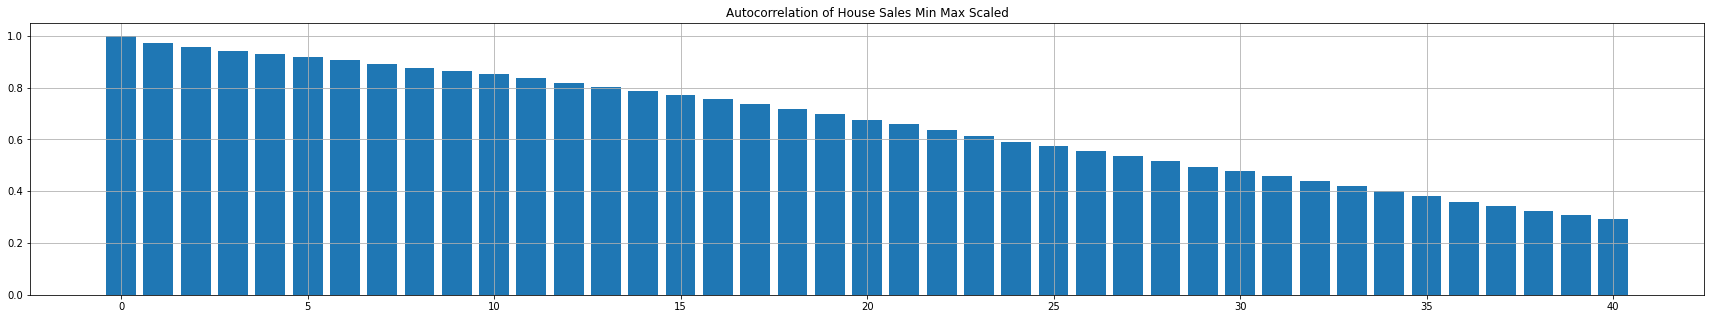

In [10]:
plt.figure(figsize=(30,5))
plt.title('Autocorrelation of House Sales Min Max Scaled')
plt.bar(range(len(acfSalesScaledNp)), acfSalesScaledNp)
plt.grid(True)

plt.savefig('image3.png')
plt.show()

In [11]:
pacfSalesScaled = pacf(houseSales.houseSalesScaled, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

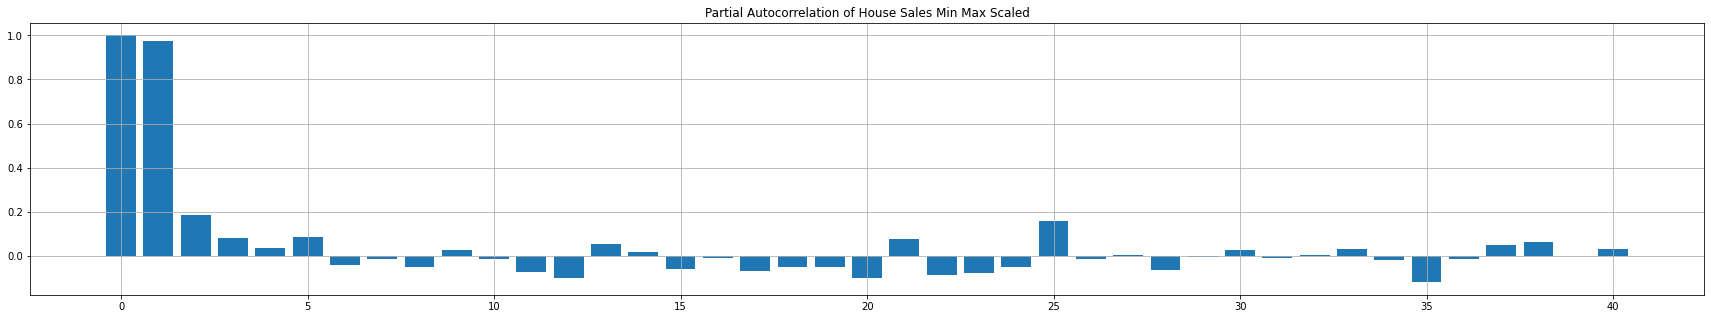

In [12]:
plt.figure(figsize=(30,5))
plt.title('Partial Autocorrelation of House Sales Min Max Scaled')
plt.bar(range(len(pacfSalesScaledNp)), pacfSalesScaledNp)
plt.grid(True)

plt.savefig('image4.png')
plt.show()

### Task 5: Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [13]:
SIZE = len(houseSales.houseSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - 2*WINDOW_SIZE
EPOCHS = 200

In [14]:
DateTrain = houseSales.index.values[0:BATCH_SIZE]
DateValid = houseSales.index.values[BATCH_SIZE:]
XTrain = houseSales.houseSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = houseSales.houseSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (601, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (601,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [15]:
tf.random.set_seed(1234)

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
    series = tf.expand_dims(series, axis=-1) # converte numpy array em tensor
    dataset = tf.data.Dataset.from_tensor_slices(series) # cria o dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # cria a as janelas
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # 'achata' o array
    dataset = dataset.map(lambda window: (window[:-1], window[-1:])) # particiona a janela entre training and label
    dataset = dataset.batch(batch_size).prefetch(1) # divide o dataset em batches
    return dataset

DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Task 6: Define and Estimate the LSTM.

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(None, 1), return_sequences=True),
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='huber_loss', optimizer=optimizer)
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1456 - val_loss: 0.1189
Epoch 2/200
1/1 [==============================] - 0s 362ms/step - loss: 0.1408 - val_loss: 0.1146
Epoch 3/200
1/1 [==============================] - 0s 189ms/step - loss: 0.1362 - val_loss: 0.1104
Epoch 4/200
1/1 [==============================] - 0s 212ms/step - loss: 0.1316 - val_loss: 0.1063
Epoch 5/200
1/1 [==============================] - 0s 207ms/step - loss: 0.1272 - val_loss: 0.1024
Epoch 6/200
1/1 [==============================] - 0s 203ms/step - loss: 0.1230 - val_loss: 0.0986
Epoch 7/200
1/1 [==============================] - 0s 203ms/step - loss: 0.1189 - val_loss: 0.0949
Epoch 8/200
1/1 [==============================] - 0s 184ms/step - loss: 0.1149 - val_loss: 0.0913
Epoch 9/200
1/1 [==============================] - 0s 190ms/step - loss: 0.1110 - val_loss: 0.0879
Epoch 10/200
1/1 [==============================] - 0s 195ms/step - loss: 0.1073 - val_loss: 0.0845
Epoch 11/200

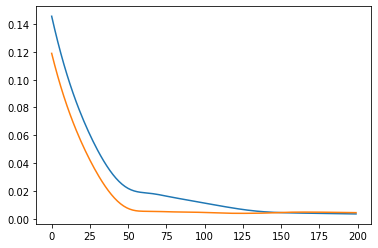

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

### Task 7: Forecast the LSTM on the Validation Set and Assess Accuracy.

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecast = model_forecast(model, houseSales.houseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1, 1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1, 1))

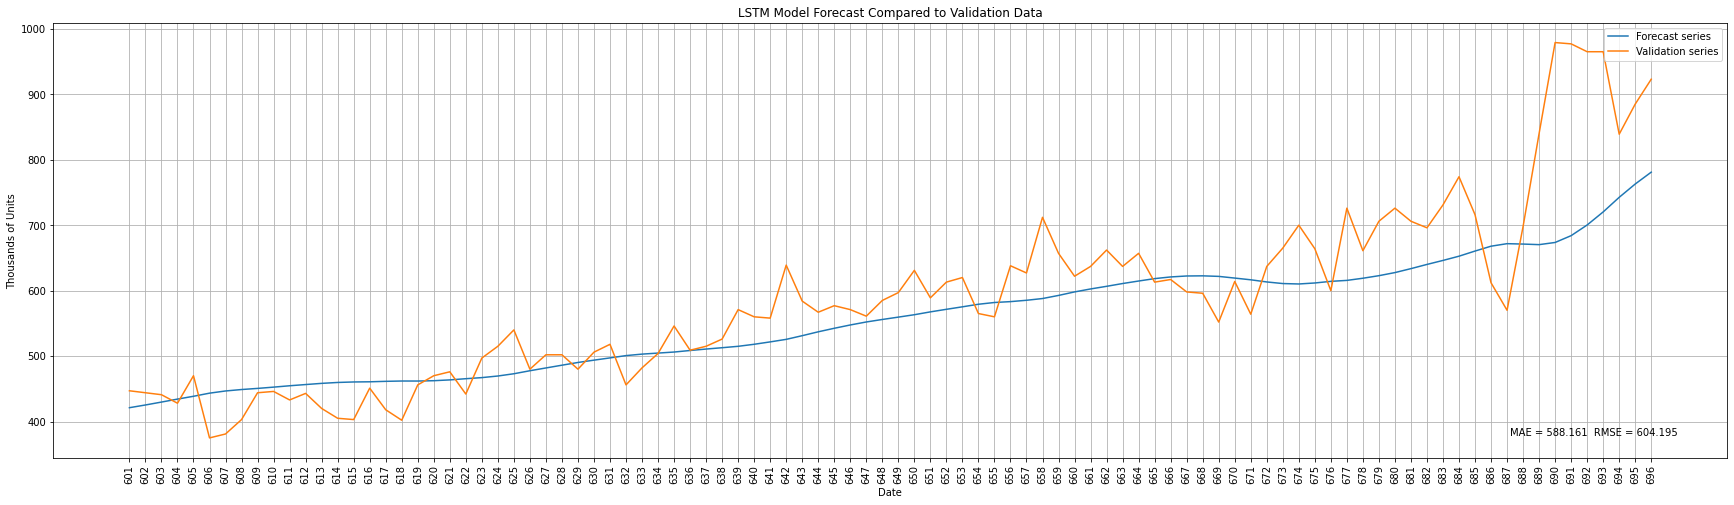

In [23]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid, Results1, label='Forecast series')
plt.plot(DateValid, np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.savefig('image5.png')